## Setup

In [1]:
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import random
# import cudf as pd
import tensorflow as tf
import isuelogit as isl
import glob

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pabloguarda/GitHub/aesuelogit


In [3]:
# Internal modules
from src.aesuelogit.models import UtilityParameters, BPRParameters, ODParameters, AESUELOGIT, NGD
from src.aesuelogit.visualizations import plot_predictive_performance
from src.aesuelogit.networks import load_k_shortest_paths, read_paths, build_fresno_network, \
    Equilibrator, sparsify_OD, ColumnGenerator, read_OD
from src.aesuelogit.etl import get_design_tensor, get_y_tensor, data_curation

In [4]:
# Seed for reproducibility
_SEED = 2022
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

## Build Fresno network

In [5]:
fresno_network = build_fresno_network()

## Read OD matrix

In [6]:
read_OD(network=fresno_network, sparse=True)

Matrix Q (1789, 1789) read in 0.1[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs


## Read paths

In [7]:
#eread_paths(network=fresno_network, update_incidence_matrices=True, filename='paths-fresno.csv')
read_paths(network=fresno_network, update_incidence_matrices=True, filename = 'paths-full-model-fresno.csv')

# For quick testing
# Q = fresno_network.load_OD(sparsify_OD(fresno_network.Q, prop_od_pairs=0.99))
# load_k_shortest_paths(network=fresno_network, k=2, update_incidence_matrices=True)

18289 paths were read in 68.6[s]              

18289 paths were loaded in the network

Updating incidence matrices

Matrix D (2413, 18289) generated in 63.2[s]               

Generating M: |####################| 98.8% Matrix C (18289, 18289) generated in 9.6[s]               



## Read spatiotemporal data

In [8]:
folderpath = isl.config.dirs['read_network_data'] + 'links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*fresno-link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df[df['date'].dt.dayofweek.between(0, 4)]
# df = df[df['date'].dt.year == 2019]

df['period'] = df['date'].astype(str) + '-' + df['hour'].astype(str)
df['period'] = df.period.map(hash)

## Data curation

In [9]:
df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

df = data_curation(df)

## Utility function

In [10]:
features_Z = ['speed_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

utility_parameters = UtilityParameters(features_Y=['tt'],
                                       features_Z=features_Z,
                                       periods = 1,
                                       initial_values={'tt': 0, 'c': 0, 's': 0, 'psc_factor': 0,
                                                       'fixed_effect': np.zeros_like(fresno_network.links)},
                                       signs={'tt': '-', 'speed_sd': '-', 'median_inc': '+', 'incidents': '-',
                                              'bus_stops': '-', 'intersections': '-'},
                                       trainables={'psc_factor': False, 'fixed_effect': False},
                                       )

utility_parameters.constant_initializer(0)

## Data processing

In [11]:
n_links = len(fresno_network.links)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year
X, Y = {}, {}

In [12]:
df.query('year == 2019')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix']].describe()

,counts,tt_ff,tt_avg,tf_inrix
count,9704.000000,166497.000000,166497.000000,166497.000000
mean,1880.469281,0.150823,0.301647,0.192740
std,791.369747,0.172423,0.344845,0.224399
min,3.000000,0.000000,0.000000,0.000000
25%,1361.000000,0.000000,0.000000,0.000000
50%,1787.000000,0.121000,0.242000,0.144000
75%,2302.700000,0.205000,0.410000,0.272000
max,4807.000000,2.113000,4.226000,4.605000


In [13]:
df.query('year == 2020')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix']].describe()

,counts,tt_ff,tt_avg,tf_inrix
count,9290.000000,159258.000000,159258.000000,159258.000000
mean,1822.742196,0.150823,0.301647,0.188521
std,795.855464,0.172423,0.344845,0.219121
min,31.000000,0.000000,0.000000,0.000000
25%,1275.125000,0.000000,0.000000,0.000000
50%,1715.000000,0.121000,0.242000,0.142000
75%,2242.750000,0.205000,0.410000,0.263000
max,4798.000000,2.113000,4.226000,3.775000


In [14]:
# Normalization of features to range [0,1]

df[features_Z + ['tt_avg'] + ['tt_ff']] \
    = preprocessing.MaxAbsScaler().fit_transform(df[features_Z + ['tt_avg'] + ['tt_ff']])

In [15]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in fresno_network.links:
    fresno_network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==str(link.key)])

## Training and validation sets

In [16]:
for year in sorted(df['year'].unique()):
    df_year = df[df['year'] == year]

    n_days, n_hours = len(df_year.date.unique()), len(df_year.hour.unique())

    traveltime_data = get_y_tensor(y=df_year[['tt_avg']], n_links=n_links, n_days=n_days, n_hours=n_hours)
    flow_data = get_y_tensor(y=df_year[['counts']], n_links=n_links, n_days=n_days, n_hours=n_hours)

    Y[year] = tf.concat([traveltime_data, flow_data], axis=3)

    X[year] = get_design_tensor(Z=df_year[['tt_avg'] + features_Z], n_links=n_links, n_days=n_days, n_hours=n_hours)

    tt_ff = get_design_tensor(Z=df_year[['tt_ff']], n_links=n_links, n_days=n_days, n_hours=n_hours)

2022-05-31 11:50:05.626432: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# Prepare the training and validation dataset

X_train, X_val, Y_train, Y_val = X[2019], X[2020], Y[2019], Y[2020]

X_train, X_val, Y_train, Y_val = [tf.constant(i) for i in [X_train, X_val, Y_train, Y_val]]

## Learning parameters

In [18]:
_EPOCHS = 10
_BATCH_SIZE = 4
_LR = 5e-1  # Default is 1e-3. With 1e-1, training becomes unstable

## Network equilibrium predictor

In [19]:
equilibrator = Equilibrator(
    network=fresno_network,
    # paths_generator=paths_generator,
    utility=utility_parameters,
    max_iters=100,
    method='fw',
    iters_fw=50,
    accuracy=1e-4,
)

column_generator = ColumnGenerator(equilibrator=equilibrator,
                                   utility=utility_parameters,
                                   n_paths=0,
                                   ods_coverage=0.1,
                                   ods_sampling='sequential',
                                   # ods_sampling='demand',
                                   )

## Models

In [21]:
models = dict.fromkeys(['m1', 'm2', 'm3', 'm4'], True)
# models = dict.fromkeys(['m1', 'm2', 'm3', 'm4'], False)
# models['m1'] = True
# models['m2'] = True
# models['m3'] = True
# models['m4'] = True

In [22]:
train_losses_dfs = {}
val_losses_dfs = {}

### Model 1: Benchmark of aesuelogit and isuelogit


model 1: Benchmark of aesuelogit and isuelogit (utility only)

Epoch: 0, n_train: 23, n_test: 22

SUE via fw (max iters: 100)

Equilibrium gaps: ['0E+00']
Initial Fisk Objective: -152,811.47
Final Fisk Objective: -152,811.47
Improvement Fisk Objective: 0.00%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 93.9 [s]


0: train_loss=2.3e+06,  val_loss=2.4e+06, train_loss tt=0.013, val_loss tt=0.013, train_loss flow=2.3e+06, val_loss flow=2.4e+06, train_loss bpr=0.0029, val_loss bpr=0.0027, theta = [0. 0. 0. 0. 0. 0.], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =8e-16, time:  132.4
val generalization error =0.86, 

Epoch: 1, n_train: 23, n_test: 22

SUE via fw (max iters: 100)

Equilibrium gaps: ['0E+00']
Initial Fisk Objective: -1,624,357.99
Final Fisk Objective: -1,622,826.64
Improvement Fisk Objective: 0.09%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 105.1 [s]


1: train_loss=1.6e+06,  val_loss=1.7e+06, train_loss tt=0.00

/Users/pabloguarda/GitHub/aesuelogit/src/aesuelogit/visualizations.py:65: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


theta = {'tt': -1.935538605890071, 'speed_sd': 0.0, 'median_inc': 0.0, 'incidents': -5.470610158763652, 'bus_stops': 0.0, 'intersections': -0.7864337563053643}
alpha =  0.15, beta  =  4.00
Avg abs diff of observed and estimated OD:  0.00


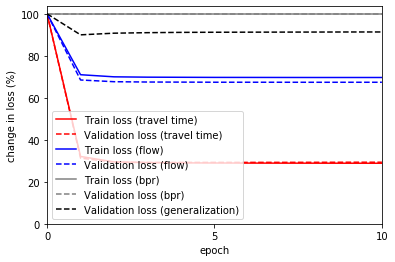

In [23]:
if models['m1']:
    print('\nmodel 1: Benchmark of aesuelogit and isuelogit (utility only)')

    _LR = 5e-1

    optimizer = NGD(learning_rate=_LR)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 # initial_values=0.6 * tntp_network.q.flatten(),
                                 initial_values=fresno_network.q.flatten(),
                                 true_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=False)

    model_1 = AESUELOGIT(
        key='model_1',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator = equilibrator,
        column_generator = column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters
    )

    train_losses_dfs['model_1'], val_losses_dfs['model_1'] = model_1.train(
        X_train, Y_train, X_val, Y_val,
        optimizer=optimizer,
        generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        loss_weights={'od': 0, 'theta': 0, 'tt': 0, 'flow': 1, 'bpr': 0},
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_losses_dfs['model_1'], val_losses=val_losses_dfs['model_1'])
    
    plt.show()

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(model_1.theta.numpy())))}")
    print(f"alpha = {model_1.alpha: 0.2f}, beta  = {model_1.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(model_1.q - fresno_network.q.flatten())): 0.2f}")

### Model 2: OD + utility estimation with historic OD


model 2: OD + utility estimation with historic OD

Epoch: 0, n_train: 23, n_test: 22

SUE via fw (max iters: 100)

Equilibrium gaps: ['0E+00']
Initial Fisk Objective: -152,811.47
Final Fisk Objective: -152,811.47
Improvement Fisk Objective: 0.00%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 91.0 [s]


0: train_loss=2.3e+06,  val_loss=2.4e+06, train_loss tt=0.013, val_loss tt=0.013, train_loss flow=2.3e+06, val_loss flow=2.4e+06, train_loss bpr=0.0029, val_loss bpr=0.0027, theta = [0. 0. 0. 0. 0. 0.], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =8e-16, time:  120.6
val generalization error =0.86, 

Epoch: 1, n_train: 23, n_test: 22

SUE via fw (max iters: 100)

Equilibrium gaps: ['0E+00']
Initial Fisk Objective: -1,282,927.38
Final Fisk Objective: -1,282,678.77
Improvement Fisk Objective: 0.02%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 105.9 [s]


1: train_loss=7.7e+05,  val_loss=8e+05, train_loss tt=0.00029, val_loss 

/Users/pabloguarda/GitHub/aesuelogit/src/aesuelogit/visualizations.py:65: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


theta = {'tt': -3.2752591391163475, 'speed_sd': -0.37639985597419784, 'median_inc': 0.0, 'incidents': -2.6762134399341697, 'bus_stops': 0.0, 'intersections': -2.920184204292795}
alpha =  0.15, beta  =  4.00
Avg abs diff of observed and estimated OD:  8.98


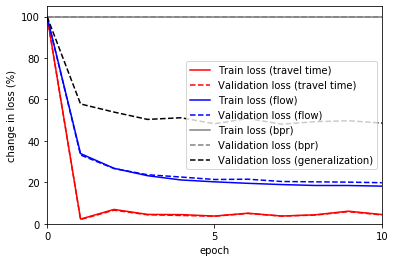

In [24]:
if models['m2']:
    print('\nmodel 2: OD + utility estimation with historic OD')
    
    # optimizer = tf.keras.optimizers.Adagrad(learning_rate=_LR)
    optimizer = tf.keras.optimizers.Adam(learning_rate=_LR)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 initial_values=fresno_network.q.flatten(),
                                 historic_values={1: fresno_network.q.flatten()},
                                 trainable=True)

    model_2 = AESUELOGIT(
        key='model_2',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_losses_dfs['model_2'], val_losses_dfs['model_2'] = model_2.train(
        X_train, Y_train, X_val, Y_val,
        optimizer=optimizer,
        generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        loss_weights={'od': 1, 'theta': 0, 'tt': 1, 'flow': 1, 'bpr': 0},
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_losses_dfs['model_2'], val_losses=val_losses_dfs['model_2'])
    
    plt.show()

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(model_2.theta.numpy())))}")
    print(f"alpha = {model_2.alpha: 0.2f}, beta  = {model_2.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(model_2.q - fresno_network.q.flatten())): 0.2f}")

### Model 3: ODLUE + link performance parameters without historic OD matrix


model 3: ODLUE + link performance parameters without historic OD matrix

Epoch: 0, n_train: 23, n_test: 22

SUE via fw (max iters: 100)

Equilibrium gaps: ['0E+00']
Initial Fisk Objective: -152,811.47
Final Fisk Objective: -152,811.47
Improvement Fisk Objective: 0.00%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 79.8 [s]


0: train_loss=2.3e+06,  val_loss=2.4e+06, train_loss tt=0.0002, val_loss tt=0.0002, train_loss flow=2.3e+06, val_loss flow=2.4e+06, train_loss bpr=0.00069, val_loss bpr=0.00063, theta = [0. 0. 0. 0. 0. 0.], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 1, avg abs diff demand =8e-16, time:  108.5
val generalization error =0.86, 

Epoch: 1, n_train: 23, n_test: 22

SUE via fw (max iters: 100)

Equilibrium gaps: ['0E+00']
Initial Fisk Objective: -1,623,088.64
Final Fisk Objective: -1,623,088.64
Improvement Fisk Objective: 0.00%
Final gap: 0E+00. Acc. bound: 1E-04. Time: 84.9 [s]


1: train_loss=7.5e+05,  val_loss=7.9e+05, train

/Users/pabloguarda/GitHub/aesuelogit/src/aesuelogit/visualizations.py:65: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


theta = {'tt': -4.804940902192045, 'speed_sd': -0.5578203373182022, 'median_inc': 0.0, 'incidents': -4.009731437414267, 'bus_stops': 0.0, 'intersections': -4.026924151396852}
alpha =  0.00, beta  =  1.00
Avg abs diff of observed and estimated OD:  11.39


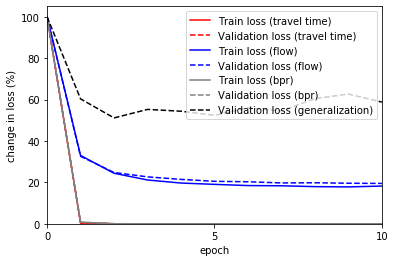

In [25]:
if models['m3']:

    print('\nmodel 3: ODLUE + link performance parameters without historic OD matrix')

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 1},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables={'alpha': True, 'beta':True},
                                   )

    od_parameters = ODParameters(key='od',
                                 periods=1,
                                 initial_values=fresno_network.q.flatten(),
                                 # historic_values={1: fresno_network.q.flatten()},
                                 trainable=True)

    model_3 = AESUELOGIT(
        key='model_3',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_losses_dfs['model_3'], val_losses_dfs['model_3'] = model_3.train(
        X_train, Y_train, X_val, Y_val,
        optimizer=optimizer,
        generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        loss_weights={'od': 0, 'theta': 0, 'tt': 1, 'flow': 1, 'bpr': 0},
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_losses_dfs['model_3'], val_losses=val_losses_dfs['model_3'])
    
    plt.show()

    print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(model_3.theta.numpy())))}")
    print(f"alpha = {model_3.alpha: 0.2f}, beta  = {model_3.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(model_3.q - fresno_network.q.flatten())): 0.2f}")

### Model 4: Time specific utility and OD, link performance parameters, no historic OD


model 4: Time specific utility and OD, link performance parameters, no historic OD

Epoch: 0, n_train: 23, n_test: 22
0: train_loss=2.3e+06,  val_loss=2.4e+06, train_loss tt=0.013, val_loss tt=0.013, train_loss flow=2.3e+06, val_loss flow=2.4e+06, train_loss bpr=0.0029, val_loss bpr=0.0027, theta = [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.15, avg beta = 4, avg abs diff demand =8e-16, time:  22.3

Epoch: 1, n_train: 23, n_test: 22
1: train_loss=8.3e+05,  val_loss=9e+05, train_loss tt=1.3e-05, val_loss tt=1.2e-05, train_loss flow=8.3e+05, val_loss flow=9e+05, train_loss bpr=1.4e-05, val_loss bpr=1.3e-05, theta = [[-2.5166 -2.7298  0.     -2.5438  0.     -2.2564]
 [-2.5216 -2.619   0.     -2.666   0.     -2.266 ]
 [-2.4838 -2.4551  0.     -2.6491  0.     -2.3201]], vot = nan, psc_factor = 0.0, avg abs theta fixed effect = 0, avg alpha = 0.01, avg beta = 4, avg abs diff demand =6.6, time:  8

/Users/pabloguarda/GitHub/aesuelogit/src/aesuelogit/visualizations.py:65: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


features = ['tt', 'speed_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']
theta = [[-6.072  -4.182   0.     -4.698   0.     -5.8283]
 [-6.3109 -2.7663  0.     -5.6591  0.     -5.5655]
 [-6.1376 -1.9529  0.     -5.3152  0.     -5.4688]]
alpha =  0.00, beta  =  4.00
Avg abs diff of observed and estimated OD:  12.38


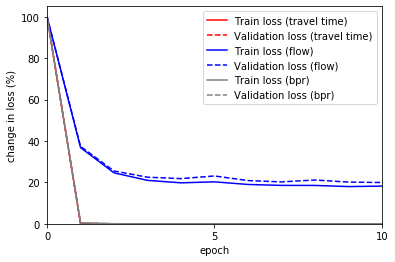

In [26]:
if models['m4']:
    print('\nmodel 4: Time specific utility and OD, link performance parameters, no historic OD')

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           periods=3,
                                           initial_values={'tt': 0, 'c': 0, 's': 0, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(fresno_network.links)},
                                           signs={'tt': '-', 'speed_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': False},
                                           )

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 0.1, 'beta': 1},
                                   trainables={'alpha': True, 'beta': False},
                                   # trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 periods=3,
                                 initial_values=fresno_network.q.flatten(),
                                 trainable=True)

    model_4 = AESUELOGIT(
        key='model_4',
        network=fresno_network,
        dtype=tf.float64,
        equilibrator=equilibrator,
        column_generator=column_generator,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_losses_dfs['model_4'], val_losses_dfs['model_4'] = model_4.train(
        X_train, Y_train, X_val, Y_val,
        optimizer=optimizer,
        #generalization_error={'train': False, 'validation': True},
        batch_size=_BATCH_SIZE,
        loss_weights={'od': 0, 'theta': 0, 'tt': 1, 'flow': 1, 'bpr': 0},
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_losses_dfs['model_4'], val_losses=val_losses_dfs['model_4'])
    
    plt.show()

    print(f"features = {utility_parameters.features}")
    print(f"theta = {model_4.theta.numpy()}")
    print(f"alpha = {model_4.alpha: 0.2f}, beta  = {model_4.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(model_4.q - fresno_network.q.flatten())): 0.2f}")